# Flat Clustering (K-Medoids)
---
  
**K-Medoids**  
- Alternative to K-Means. The medoid is the existing object most central to the cluster. Only needs the pairwise distances.
- It is more robust to noise and outliers because it minimizes a sum of pairwise dissimilarities instead of a sum of squared Euclidean distances.
- A medoid can be defined as the object of a cluster whose average dissimilarity to all the objects in the cluster is minimal, that is, it is a most centrally located point in the cluster.  


## Env Preparation

In [20]:
import os
import sys
os.chdir('/app/')
print('Workdir: ', os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

Workdir:  /app


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")## Data

%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [22]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data

In [23]:
data = pd.read_csv(JP(paths['data'],'bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


## TFIDF

In [24]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print('Clusters k = ', NUM_CLUSTERS)


Clusters k =  5


In [26]:
vectorizer = TfidfVectorizer(
    min_df=.05,
    max_df=.8,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

# vectorizer

In [27]:
tfidf = vectorizer.fit_transform(data['processed'].copy())
tfidf_df = pd.DataFrame(
    tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
0,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.027,0.000,...,0.000,0.000,0.000,0.000,0.000,0.029,0.000,0.000,0.038,0.000
1,0.000,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,0.299,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.239,0.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,...,0.094,0.316,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000


**There are 460 unique grams in 2225 documents with the given constraints**

## Moving to a Catalog Format

In [28]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [29]:
catalog = Catalog()
catalog.documents = documents

In [30]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
tfidf.representation.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
0,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.027,0.000,...,0.000,0.000,0.000,0.000,0.000,0.029,0.000,0.000,0.038,0.000
1,0.000,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,0.299,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.239,0.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,...,0.094,0.316,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Clustering

In [32]:
from sklearn_extra.cluster import KMedoids

def kmedoids_clustering(
    model, # class Model
    num_clusters:int=4,
    metric='cosine',
    random_state=46):
    '''
    TODO: Consider MiniBatchKMeans
    Args:
        - model: Trained instance of class Model
        - num_clusters: Number of Clusters to look for

    Returns: 
        - Clustering model instance
    '''
    km = KMedoids(
        n_clusters=num_clusters,
        metric=metric,
        random_state=random_state)
    return km.fit(model.representation)

In [33]:
def words_per_cluster(
    model,
    clusters:KMedoids):
    '''
    Return the most important words per cluster
        The k closest to the medoid of that cluster

    Args:
        - Clustering model instance
    
    Returns:
        - Dict key='medoid id', value=words_closest_to_medoid
    '''
    cluster_words = defaultdict(list)
    medoids = clusters.cluster_centers_
    
    # For each centroid
    for i,medoid in enumerate(medoids):
        # Bring K most similar words to centroid i
        closests_words_to_medoid = medoid.argsort()[::-1] 
        for idx in closests_words_to_medoid:
            cluster_words[i].append(model.id2token[idx])
    return cluster_words

In [34]:
clusters = kmean_clustering(model=tfidf,num_clusters=NUM_CLUSTERS)
BEST_WORDS_PER_CLUSTER = words_per_cluster(tfidf,clusters)

#### Save Model

In [16]:
name = 'kmedoids_clustering_K_5.pkl'
with open(JP(paths['results'],name),'wb') as obj:
    pickle.dump(clusters, obj)

In [35]:
for c in range(NUM_CLUSTERS):
    print('Cluster {}: {} documents :: Best words: {}'.format(
        c, sum(clusters.labels_==c), BEST_WORDS_PER_CLUSTER[c][:5]))

Cluster 0: 509 documents :: Best words: ['game', 'win', 'team', 'try', 'leave']
Cluster 1: 319 documents :: Best words: ['game', 'new', 'video', 'technology', 'expect']
Cluster 2: 734 documents :: Best words: ['government', 'agree', 'people', 'trial', 'fear']
Cluster 3: 398 documents :: Best words: ['people', 'net', 'digital', 'go', 'business']
Cluster 4: 265 documents :: Best words: ['go', 'come', 'number', 'long', 'right']


**How can be simmilar words the most important one for different clusters?**


**RECALL REAL DISTRIBUTION OF CATEGORIES**


In [18]:
print(data.category.value_counts())


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


## Words per Cluster

In [36]:
medoids = pd.DataFrame(clusters.cluster_centers_,columns=tfidf_df.columns)
medoids.index = range(1,NUM_CLUSTERS+1)
# medoids.index = ['M{}'.format(i) for i in range(NUM_CLUSTERS)]
medoids.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.356,0.037,0.000,0.000,0.045,0.000,0.043,0.036
2,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.052,0.000,0.061,...,0.000,0.000,0.000,0.000,0.000,0.113,0.077,0.000,0.049,0.000
3,0.000,0.019,0.000,0.000,0.000,0.035,0.067,0.030,0.021,0.000,...,0.011,0.000,0.063,0.000,0.035,0.000,0.034,0.016,0.078,0.018
4,0.051,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.000,...,0.000,0.000,0.035,0.000,0.000,0.074,0.038,0.000,0.024,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.179,...,0.000,0.000,0.106,0.000,0.000,0.166,0.057,0.000,0.109,0.091


---

# Plotting the WordClouds


In [37]:
%matplotlib inline
from wordcloud import WordCloud

#### Helper Functions for Plotting

In [38]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    print(n_rows,n_cols)
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    return fig,axs # .reshape(n_plots,-1)

In [39]:
def cluster_to_wordcloud(
    df, max_words=200, use_mask=False, bgcolor='black'):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color=bgcolor).generate_from_frequencies(
            frequencies=dict(zip(df.word, df.score)))
    return wordcloud


In [40]:
def plot_centroids_as_wordclouds(
    word_scores,
    NUM_CLUSTERS = None,
    max_words_per_cloud=100, 
    use_mask=False, n_cols=2, figsize=(15,15)):

    if not NUM_CLUSTERS:
        NUM_CLUSTERS = word_scores.cluster.nunique()

    n_plots = NUM_CLUSTERS
    _, axs = define_subplots(n_cols,n_plots, figsize)
    
    for c in range(NUM_CLUSTERS):
        wordcloud = cluster_to_wordcloud(
            df=word_scores[word_scores.cluster == c+1],
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        axs[c // n_cols, c % n_cols].imshow(wordcloud)
        axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return


### Data to desired format

In [62]:
scores = pd.melt(medoids.rename_axis('cluster').reset_index(), 
                 id_vars=['cluster'], var_name='word', value_name='score')

**Centroid approach has entries with 0!**

In [59]:
scores_ = scores[scores['score'] > 0]
scores_.head(15)

,cluster,word,score,score_
1,2,able,0.104,0.218
3,4,able,0.051,0.108
7,3,accept,0.019,0.039
27,3,accuse,0.035,0.074
32,3,act,0.067,0.141
36,2,action,0.052,0.109
37,3,action,0.030,0.063
42,3,add,0.021,0.043
43,4,add,0.035,0.073
46,2,admit,0.061,0.127


3 2


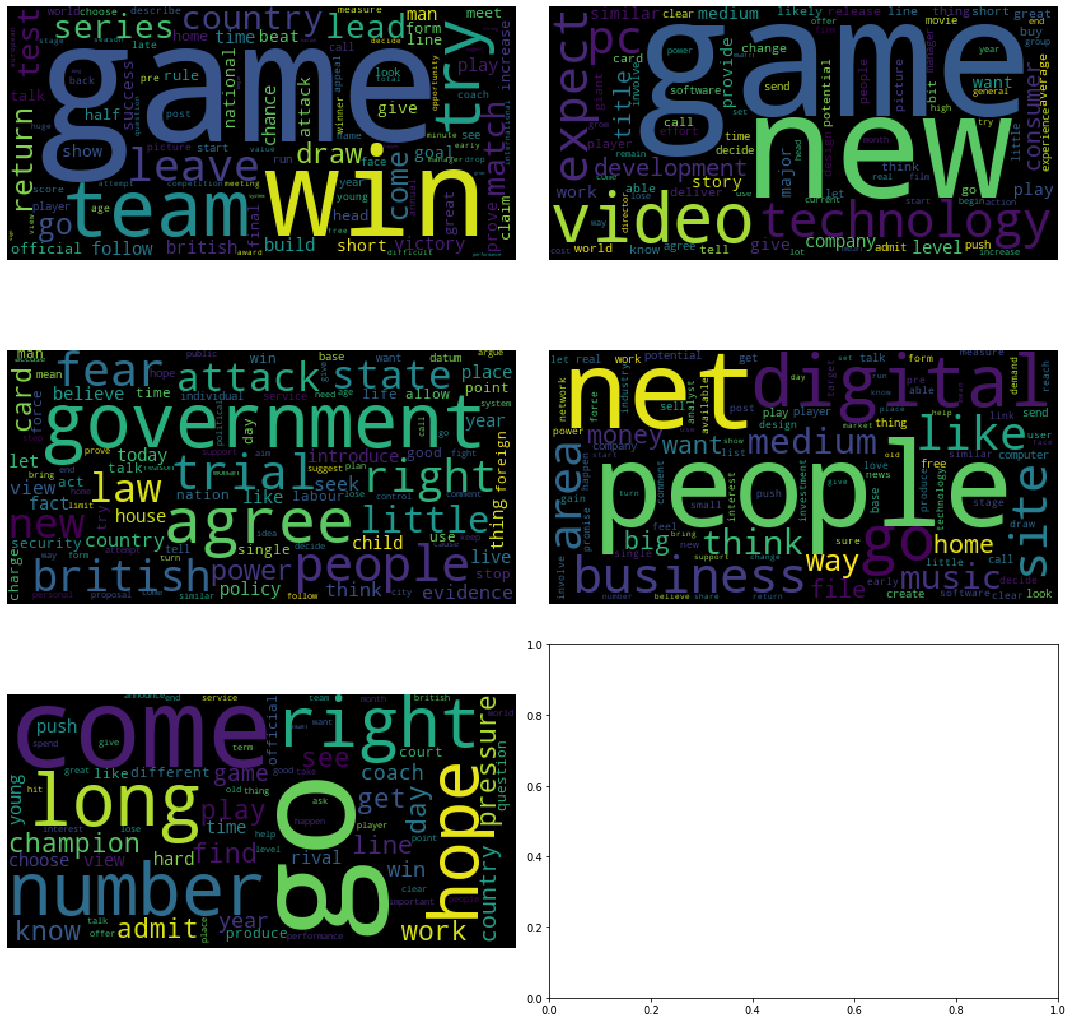

In [61]:
plot_centroids_as_wordclouds(scores_, n_cols=2)

# Validation

**According to importants words of cluster lets assigned a classification:**

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [28]:
cluster_preds = ['sport', 'entertainment', 'business', 'tech', 'politics']  
d = dict(zip(range(NUM_CLUSTERS), cluster_preds))
d

{0: 'sport', 1: 'entertainment', 2: 'business', 3: 'tech', 4: 'politics'}

In [29]:
data['predict'] = [d[i] for i in clusters.labels_]

In [30]:
print(data.category.value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [31]:
print(data.predict.value_counts())

business         734
sport            509
tech             398
entertainment    319
politics         265
Name: predict, dtype: int64


In [32]:
cm = confusion_matrix(
    y_true=data.category, 
    y_pred = data.predict, 
    labels=cluster_preds)

pd.DataFrame(cm, columns=cluster_preds, index=cluster_preds)

,sport,entertainment,business,tech,politics
sport,364,9,22,21,95
entertainment,107,52,64,66,97
business,14,122,245,80,49
tech,18,128,33,218,4
politics,6,8,370,13,20
